# Hundai Kaggle Competition
### Analyst - Rahul Gupta
### Domain  - Covid-19
### S-Date  - 01-05-2020
### E-Date  - 03-05-2020
### Tot-Time- 12 Hours
### D-Type  - Time Series
### Goals   - Clustering and Forecasting
### Source - https://www.kaggle.com/c/covid19-global-forecasting-week-2/data

## Importing required modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as sch
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tqdm import tqdm
import datetime as dt
from sklearn.cluster import AgglomerativeClustering

In [2]:
pd.set_option('display.max_columns', 99)
pd.set_option('display.max_rows', 200)

# Key Features from Data:
- Training data contains daywise confirm cases and deaths for each State/Country/Region for past dates
 - id is unique identifier at date and State/Country/Region level
- Test data contains daywise details for each State/Country/Region for past and future dates
 - forecastid is unique identifier at date and State/Country/Region level
- Submission data contains expected result for the confirm cases and deaths for the test data forecastid columns
- Training data have missing data at State (Province_State) level
- Training data have set Rest of the Country_Region area data with missing Province_State
- Training data have  Only 8 Country_Region have multiple Province_State others are missing Province_State
- Training data have Confirm cases and death data are cumulative at date level but have some discripancy (98% cumulative)
- Training data have Some Province_State are common in different Country_Region
- Training data is for 70 days, between 22-jan-2020 to 31-march-2020
- Test data is need to be predicted from 19-mar-2020 to 30-apr-2020


## Reading input files

In [3]:
train = pd.read_csv("train.csv", keep_default_na=False)

In [4]:
test = pd.read_csv("test.csv", keep_default_na=False)

In [5]:
submission = pd.read_csv("submission.csv", keep_default_na=False)

## Analysis of test, train and submission data

In [6]:
print(
    train.shape, test.shape, submission.shape
)

((20580, 6), (12642, 4), (12642, 3))


In [7]:
print(train.dtypes)
print(test.dtypes)
print(submission.dtypes)

Id                  int64
Province_State     object
Country_Region     object
Date               object
ConfirmedCases    float64
Fatalities        float64
dtype: object
ForecastId         int64
Province_State    object
Country_Region    object
Date              object
dtype: object
ForecastId        int64
ConfirmedCases    int64
Fatalities        int64
dtype: object


In [8]:
train.head(5)

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,,Afghanistan,2020-01-22,0.0,0.0
1,2,,Afghanistan,2020-01-23,0.0,0.0
2,3,,Afghanistan,2020-01-24,0.0,0.0
3,4,,Afghanistan,2020-01-25,0.0,0.0
4,5,,Afghanistan,2020-01-26,0.0,0.0


In [9]:
test.head(5)

,ForecastId,Province_State,Country_Region,Date
0,1,,Afghanistan,2020-03-19
1,2,,Afghanistan,2020-03-20
2,3,,Afghanistan,2020-03-21
3,4,,Afghanistan,2020-03-22
4,5,,Afghanistan,2020-03-23


In [10]:
submission.head(5)

,ForecastId,ConfirmedCases,Fatalities
0,1,1,1
1,2,1,1
2,3,1,1
3,4,1,1
4,5,1,1


## Analysis for each attribute of train data

In [11]:
# test the missing type data
def mis_test(attr):
    return  len(attr.unique()), [x for x in attr.unique() if x == float("NaN") or x == ""]

In [12]:
train.shape

(20580, 6)

In [13]:
mis_test(train.Id)

(20580, [])

In [14]:
mis_test(train.Province_State)

(126, [''])

In [15]:
mis_test(train.Country_Region)

(173, [])

In [16]:
mis_test(train.Date)

(70, [])

In [17]:
mis_test(train.ConfirmedCases)

(1536, [])

In [18]:
mis_test(train.Fatalities)

(328, [])

In [19]:
train.describe()

,Id,ConfirmedCases,Fatalities
count,20580.000000,20580.000000,20580.000000
mean,14685.500000,514.939116,21.080952
std,8487.230117,4541.261768,287.758197
min,1.000000,0.000000,0.000000
25%,7335.750000,0.000000,0.000000
50%,14685.500000,0.000000,0.000000
75%,22035.250000,35.000000,0.000000
max,29370.000000,105792.000000,12428.000000


## Test for Province_State vs Country_Region

In [20]:
# check for Country_Region having more than one Province_State have any missing entry or not
country_list = []
df = train.groupby(train.Country_Region).nunique()
for i in df[df.Province_State > 1].index:
    z = [x for x in train[train.Country_Region == i].Province_State.unique() if x == ""]
    k = []
    if z:
        k = train[train.Country_Region == i].Province_State.unique()
        country_list.append(i)
    print(i, z, k)
print(country_list)

('Australia', [], [])
('Canada', [], [])
('China', [], [])
('Denmark', [''], array(['Faroe Islands', 'Greenland', ''], dtype=object))
('France', [''], array(['French Guiana', 'French Polynesia', 'Guadeloupe', 'Martinique',
       'Mayotte', 'New Caledonia', 'Reunion', 'Saint Barthelemy',
       'St Martin', ''], dtype=object))
('Netherlands', [''], array(['Aruba', 'Curacao', 'Sint Maarten', ''], dtype=object))
('US', [], [])
('United Kingdom', [''], array(['Bermuda', 'Cayman Islands', 'Channel Islands', 'Gibraltar',
       'Isle of Man', 'Montserrat', ''], dtype=object))
['Denmark', 'France', 'Netherlands', 'United Kingdom']


In [21]:
train[train.Country_Region.isin(country_list)].groupby(
    ["Country_Region", "Province_State"]
).count()

Id  Date  ConfirmedCases  Fatalities
Country_Region Province_State                                        
Denmark                          70    70              70          70
               Faroe Islands     70    70              70          70
               Greenland         70    70              70          70
France                           70    70              70          70
               French Guiana     70    70              70          70
               French Polynesia  70    70              70          70
               Guadeloupe        70    70              70          70
               Martinique        70    70              70          70
               Mayotte           70    70              70          70
               New Caledonia     70    70              70          70
               Reunion           70    70              70          70
               Saint Barthelemy  70    70              70          70
               St Martin         70    70              70          70
Netherlands                      70    70              70          70
               Aruba             70    70              70          70
               Curacao           70    70              70          70
               Sint Maarten      70    70              70          70
United Kingdom                   70    70              70          70
               Bermuda           70    70              70          70
               Cayman Islands    70    70              70          70
               Channel Islands   70    70              70          70
               Gibraltar         70    70              70          70
               Isle of Man       70    70              70          70
               Montserrat        70    70              70          70

## Impute missing value of Province_State with Country_Region as missing value represents rest or whole of the Country_Region

In [22]:
def add_location(df):
    df['Province_State'] = df.apply(
        lambda row: row['Country_Region'] if row['Province_State'] == "" else row['Province_State'],
        axis=1
    )
    df['Location'] = df['Country_Region'] + "-" + df['Province_State'] 
    return df

train = add_location(train)
test = add_location(test)

In [23]:
df_1 = train[['Location','Province_State', 'Country_Region']].groupby("Location").nunique()
df_1[df_1.Country_Region > 1]

,Location,Province_State,Country_Region
Location,,,


## Check whether ConfirmedCases and Fatalities are cumulative or not
- verify result with https://www.worldometers.info/coronavirus/country/india/

In [24]:
# Its look like cumulative to India
train[train.Country_Region == "India"].tail(10)

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,Location
9440,13461,India,India,2020-03-22,396.0,7.0,India-India
9441,13462,India,India,2020-03-23,499.0,10.0,India-India
9442,13463,India,India,2020-03-24,536.0,10.0,India-India
9443,13464,India,India,2020-03-25,657.0,12.0,India-India
9444,13465,India,India,2020-03-26,727.0,20.0,India-India
9445,13466,India,India,2020-03-27,887.0,20.0,India-India
9446,13467,India,India,2020-03-28,987.0,24.0,India-India
9447,13468,India,India,2020-03-29,1024.0,27.0,India-India
9448,13469,India,India,2020-03-30,1251.0,32.0,India-India
9449,13470,India,India,2020-03-31,1397.0,35.0,India-India


In [25]:
# Get train and test start and end dates
TRAIN_START = train.Date.min()
TEST_START = test.Date.min()
TRAIN_END = train.Date.max()
TEST_END = test.Date.max()
TRAIN_START, TRAIN_END, TEST_START, TEST_END

('2020-01-22', '2020-03-31', '2020-03-19', '2020-04-30')

In [26]:
# IS data is cumulative and how much discripancy in cumulative data
latest_loc = train[train['Date'] == TRAIN_END][['Location', 'ConfirmedCases', 'Fatalities']]
max_loc = train.groupby(['Location'])[['ConfirmedCases', 'Fatalities']].max().reset_index()
check = pd.merge(latest_loc, max_loc, on='Location')
print("%match in ConfirmedCases", np.mean(check.ConfirmedCases_x == check.ConfirmedCases_y))
print("%match in Fatalities", np.mean(check.Fatalities_x == check.Fatalities_y))

('%match in ConfirmedCases', 0.9931972789115646)
('%match in Fatalities', 0.9863945578231292)


In [27]:
# Mismatch in Fatalities
check[check.Fatalities_x != check.Fatalities_y]

,Location,ConfirmedCases_x,Fatalities_x,ConfirmedCases_y,Fatalities_y
133,Iceland-Iceland,1135.0,2.0,1135.0,5.0
144,Kazakhstan-Kazakhstan,343.0,2.0,343.0,3.0
205,Slovakia-Slovakia,363.0,0.0,363.0,1.0
236,US-Hawaii,204.0,0.0,204.0,1.0


In [28]:
# Mismatch in ConfirmedCases
check[check.ConfirmedCases_x != check.ConfirmedCases_y]

,Location,ConfirmedCases_x,Fatalities_x,ConfirmedCases_y,Fatalities_y
56,China-Guizhou,146.0,2.0,147.0,2.0
128,Guyana-Guyana,12.0,2.0,20.0,2.0


## Data look's like to be cumulative by 98% match rate, force data to be cumulative

In [29]:
# Force data to be cumulative and add other relative kpi's like date change, daywise change in confirmed and fatality cases
def custom_grouping(df, column):
    dfs = []
    for loc, df in tqdm(df.groupby(column)):
        df = df.sort_values(by='Date')
        df['Fatalities'] = df['Fatalities'].cummax()
        df['ConfirmedCases'] = df['ConfirmedCases'].cummax()
        df['LogFatalities'] = np.log(df['Fatalities'] + 1)
        df['LogConfirmed'] = np.log(df['ConfirmedCases'] + 1)
        df['LogConfirmedNextDay'] = df['LogConfirmed'].shift(1)
        df['ConfirmedCasesNextDay'] = df['ConfirmedCases'].shift(1)
        df['DateNextDay'] = df['Date'].shift(1)
        df['LogFatalitiesNextDay'] = df['LogFatalities'].shift(1)
        df['FatalitiesNextDay'] = df['Fatalities'].shift(1)
        dfs.append(df)
    return pd.concat(dfs)

def calc_delta(df):
    for col in df.columns:
        if "NextDay" in col:
            df.loc[df[col].isnull(),col] = df[col.replace("NextDay", "")]
    df['LogConfirmedDelta'] = df['LogConfirmed'] - df['LogConfirmedNextDay']
    df['ConfirmedCasesDelta'] = df['ConfirmedCases'] - df['ConfirmedCasesNextDay']
    df['LogFatalitiesDelta'] =  df['LogFatalities'] - df['LogFatalitiesNextDay']
    df['FatalitiesDelta'] = df['Fatalities'] - df['FatalitiesNextDay']
    df['FatalitiesDelta'] = df['Fatalities'] - df['FatalitiesNextDay']
    df['DateDelta'] = (pd.to_datetime(df['Date']) - pd.to_datetime(df['DateNextDay'])).dt.days
    return df

In [30]:
train_new = custom_grouping(train, ["Location"])
train_new = calc_delta(train_new)

100%|██████████| 294/294 [00:03<00:00, 94.69it/s] 


In [31]:
# check for any missing date
df_test = train_new.groupby(["Location", "DateDelta"])[["Id"]].count()
df_test[df_test.Id.isin(range(2,69))]

,,Id
Location,DateDelta,


In [32]:
train_new.to_csv("clean_train.csv", index=False)

---

# Task 1: Clustering of data
- We have tried 2 KMeans and Agglomerative Clustering teehniques
- Identify number of clusters by using elbow method as well as dendograms
- Agglomerative Clustering is preferred as data is not spherical
- dendograms easily shows the proper hierarchy and distance between the clusters

## Analysis of daywise change in ConfirmedCases and Fatalities
- To analyse the growth rate and death rate

In [33]:
# Remove redundant data for countries if there is no confirm case at that period of time
train_clust = train_new[train_new.ConfirmedCases > 0]

## Analysis for top 10 Country_Region
- To identify the growth and death rate
- Calculate top 10 contryies having higher cases and deaths
- check mean and median per Country_Region for top 10 countries from new cases and deaths

In [34]:
df2 = train_clust[train_clust.Date == TRAIN_END].groupby(["Country_Region"]).sum()[["ConfirmedCases", "Fatalities"]]
df2["case_rank"] = df2["ConfirmedCases"].rank(method="dense", ascending=False)
df2["fat_rank"] = df2["Fatalities"].rank(method="dense", ascending=False)

In [35]:
df2.sort_values(by=["case_rank", "fat_rank"]).head(10)

,ConfirmedCases,Fatalities,case_rank,fat_rank
Country_Region,,,,
US,188018.0,3871.0,1.0,3.0
Italy,105792.0,12428.0,2.0,1.0
Spain,95923.0,8464.0,3.0,2.0
China,82280.0,3309.0,4.0,5.0
Germany,71808.0,775.0,5.0,9.0
France,52827.0,3532.0,6.0,4.0
Iran,44605.0,2898.0,7.0,6.0
United Kingdom,25471.0,1793.0,8.0,7.0
Switzerland,16605.0,433.0,9.0,11.0


In [36]:
df2.sort_values(by=["fat_rank", "case_rank"]).head(10)

,ConfirmedCases,Fatalities,case_rank,fat_rank
Country_Region,,,,
Italy,105792.0,12428.0,2.0,1.0
Spain,95923.0,8464.0,3.0,2.0
US,188018.0,3871.0,1.0,3.0
France,52827.0,3532.0,6.0,4.0
China,82280.0,3309.0,4.0,5.0
Iran,44605.0,2898.0,7.0,6.0
United Kingdom,25471.0,1793.0,8.0,7.0
Netherlands,12667.0,1040.0,12.0,8.0
Germany,71808.0,775.0,5.0,9.0


In [37]:
df3 = train_clust.set_index("Country_Region")[
    ["Date", "ConfirmedCasesDelta", "FatalitiesDelta", "LogConfirmedDelta", "LogFatalitiesDelta"]
].join(
    df2[df2.case_rank <= 10],
    on="Country_Region",
    how="inner"
)

In [38]:
df3[["ConfirmedCasesDelta", "FatalitiesDelta", "LogConfirmedDelta", "LogFatalitiesDelta"]].groupby("Country_Region").agg(
    ["mean", "median"]
).describe()

ConfirmedCasesDelta             FatalitiesDelta            \
                     mean      median            mean    median   
count           10.000000   10.000000       10.000000  10.00000   
mean           716.114362  178.800000       47.707169   6.95000   
std            624.032968  308.307404       70.011364  18.22765   
min             35.675251    1.000000        1.436927   0.00000   
25%            174.668376    5.500000       10.295224   0.00000   
50%            552.791667   22.750000       11.975427   0.00000   
75%           1094.059799  227.625000       55.172481   4.00000   
max           1734.295082  997.000000      203.737705  58.50000   

      LogConfirmedDelta            LogFatalitiesDelta             
                   mean     median               mean     median  
count         10.000000  10.000000          10.000000  10.000000  
mean           0.228215   0.146496           0.128570   0.061052  
std            0.104902   0.109987           0.072228   0.081881  
min            0.065506   0.000192           0.019521   0.000000  
25%            0.178725   0.096785           0.068061   0.000000  
50%            0.190424   0.119941           0.144870   0.000000  
75%            0.266172   0.190058           0.165160   0.126472  
max            0.452991   0.399697           0.255745   0.201866

# Use Mean as growth and death rate from the above observation
- Mean is more close to centre of min and max values as compared to median

In [39]:
df4 = train_clust.groupby(
    ["Country_Region"]).agg(
    {
        "LogConfirmedDelta": "mean",
        "ConfirmedCasesDelta": "mean",
        "ConfirmedCases": "sum"
    }
)
df5 = train_clust[train_clust.Fatalities > 0].groupby(
    ["Country_Region"]).agg(
    {
        "LogFatalitiesDelta": "mean",
        "FatalitiesDelta": "mean",
        "Fatalities": "sum"
    }
)
data = df4.join(
    df5, "Country_Region"
).fillna(0)
df6 = data.reset_index()

In [40]:
data.head(10)

,LogConfirmedDelta,ConfirmedCases,ConfirmedCasesDelta,Fatalities,FatalitiesDelta,LogFatalitiesDelta
Country_Region,,,,,,
Afghanistan,0.139589,1225.0,4.702703,29.0,0.400000,0.160944
Albania,0.239007,2232.0,10.565217,91.0,0.714286,0.132028
Algeria,0.182641,4828.0,19.888889,324.0,2.200000,0.190333
Andorra,0.197742,2787.0,12.533333,39.0,1.200000,0.256495
Angola,0.173287,48.0,0.583333,6.0,0.666667,0.366204
Antigua and Barbuda,0.109444,61.0,0.368421,0.0,0.000000,0.000000
Argentina,0.240045,6529.0,36.344828,158.0,1.125000,0.138842
Armenia,0.202533,4099.0,17.161290,12.0,0.500000,0.231049
Australia,0.121725,36155.0,12.524725,190.0,0.243243,0.099867


## Standarization of data and identification of number of clusters
- elbow method
- dendograms

In [41]:
# Standarized all the four feature variables
mms = StandardScaler()
mms.fit(data)
data_transformed = mms.transform(data)

In [42]:
# Elbow method
Sum_of_squared_distances = []
K = range(1,25, 1)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)

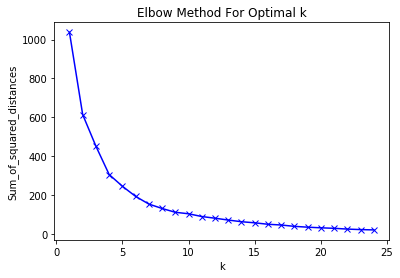

In [43]:
# plot of elbow method
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

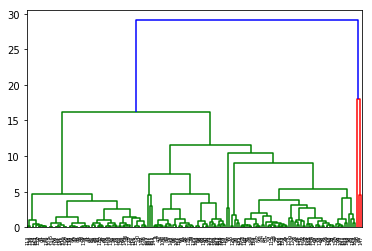

In [44]:
dendrogram = sch.dendrogram(sch.linkage(data_transformed, method='ward'))

## Apply K-means and AgglomerativeClustering with 8 clusters as confirmed by both elbow method and dendograms

In [45]:
# Number of clusters
N = 8

In [46]:
kmeans = KMeans(n_clusters=N).fit(data_transformed)
centroids = kmeans.cluster_centers_
# print(centroids)
# print(kmeans.labels_)
df6["kmeans_clusters"] = kmeans.labels_

In [47]:
model = AgglomerativeClustering(n_clusters=N, affinity='euclidean', linkage='ward')
model.fit(data_transformed)
df6["heir_clusters"] = model.labels_

In [48]:
df7 = df6.reset_index()[["Country_Region", "kmeans_clusters"]]
df7.groupby("kmeans_clusters")["Country_Region"].apply(list)

kmeans_clusters
0    [Afghanistan, Antigua and Barbuda, Australia, ...
1                                       [Italy, Spain]
2    [Albania, Argentina, Barbados, Bulgaria, Costa...
3                                              [China]
4      [Belarus, Bolivia, El Salvador, Oman, Tanzania]
5            [Mali, Portugal, Switzerland, Turkey, US]
6    [Algeria, Andorra, Angola, Armenia, Austria, B...
7                                      [Germany, Iran]
Name: Country_Region, dtype: object

In [49]:
df7 = df6.reset_index()[["Country_Region", "heir_clusters"]]
df7.groupby("heir_clusters")["Country_Region"].apply(list)

heir_clusters
0    [Algeria, Andorra, Angola, Armenia, Austria, B...
1    [Afghanistan, Antigua and Barbuda, Australia, ...
2                                      [Germany, Iran]
3                                   [Mali, Turkey, US]
4    [Albania, Argentina, Barbados, Bulgaria, Costa...
5                                              [China]
6      [Belarus, Bolivia, El Salvador, Oman, Tanzania]
7                                       [Italy, Spain]
Name: Country_Region, dtype: object

## reduce features to plot in 2-D using PCA

In [50]:
reduced_data = PCA(n_components=2).fit_transform(data_transformed)
results = pd.DataFrame(reduced_data,columns=['pca1','pca2'])

In [51]:
results.shape

(173, 2)

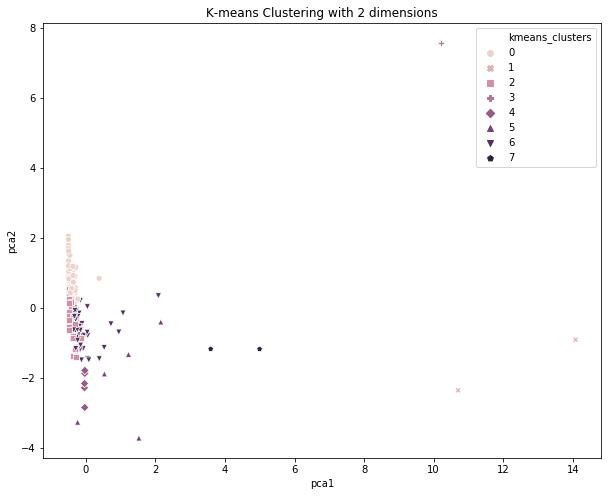

In [52]:
fig_dims = (10, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.scatterplot(x="pca1", y="pca2", hue=df6['kmeans_clusters'], style=df6['kmeans_clusters'], data=results, legend="full")
plt.title('K-means Clustering with 2 dimensions')
plt.show()

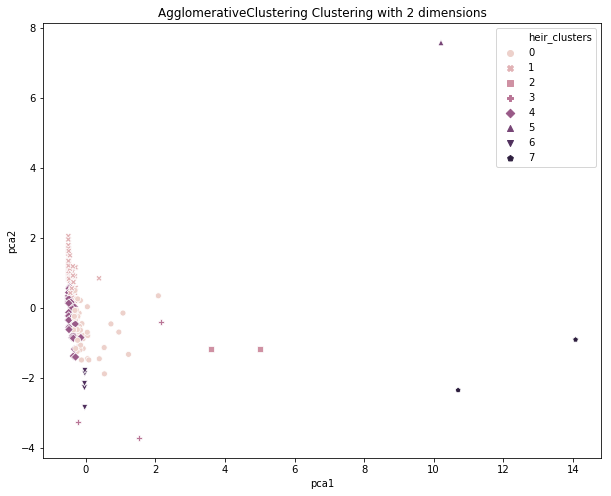

In [53]:
fig_dims = (10, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.scatterplot(x="pca1", y="pca2", hue=df6['heir_clusters'], style=df6['heir_clusters'], data=results, legend="full")
plt.title('AgglomerativeClustering Clustering with 2 dimensions')
plt.show()

## Save cluster result to csv file

In [54]:
df6.to_csv("country_clusters.csv", index=False)

___

# Task 2: Forcast future data for India
- We have set the prediction variables based on data analysis
- Use cluster level data analysis and Country_Region level data analysis to set the variables
- delta para meters are set as best of cluster and Country_Region level analysis
- decay rate is calculated for india (Country_Region) and set based on different iterations and manual tuning
- prediction for test data (only for India Country_Region)
- India trend for the month of april is moving moderately as below:
 - Confirm cases will doubled next in 5-10 days (3rd highest out of 8 clusters)
 - fatility cases will doubles next 5-8 days (3rd lowest out of 8 clusters)

In [55]:
# reading processed training data and clusters data
train_clean = pd.read_csv("clean_train.csv")
train_clusters = pd.read_csv("country_clusters.csv")

In [56]:
train_clean.dtypes, train_clusters.dtypes

(Id                         int64
 Province_State            object
 Country_Region            object
 Date                      object
 ConfirmedCases           float64
 Fatalities               float64
 Location                  object
 LogFatalities            float64
 LogConfirmed             float64
 LogConfirmedNextDay      float64
 ConfirmedCasesNextDay    float64
 DateNextDay               object
 LogFatalitiesNextDay     float64
 FatalitiesNextDay        float64
 LogConfirmedDelta        float64
 ConfirmedCasesDelta      float64
 LogFatalitiesDelta       float64
 FatalitiesDelta          float64
 DateDelta                  int64
 dtype: object, Country_Region          object
 LogConfirmedDelta      float64
 ConfirmedCases         float64
 ConfirmedCasesDelta    float64
 Fatalities             float64
 FatalitiesDelta        float64
 LogFatalitiesDelta     float64
 kmeans_clusters          int64
 heir_clusters            int64
 dtype: object)

In [57]:
# Add cluster information to training data
train_clean = train_clean.join(
    train_clusters[["Country_Region", "heir_clusters"]].set_index("Country_Region"),
    on=["Country_Region"]
)

## Identify growth and death variations for each cluster and use for prediction for each location

In [58]:
# calculate change in overall vs change in day level per cluster
deltas1 = train_clean[train_clean.Fatalities > 0].sort_values(
    by=["heir_clusters", "Country_Region", "Date"]
).groupby(
    ["heir_clusters", "Country_Region", "Date"]
)[
    ["LogConfirmed", "LogConfirmedDelta", "LogFatalities", "LogFatalitiesDelta"]
].prod().reset_index().groupby(
    ["heir_clusters", "Date"]
)[
    ["LogConfirmed", "LogConfirmedDelta", "LogFatalities", "LogFatalitiesDelta"]
].std().reset_index().groupby(
    ["heir_clusters"]
).mean()

In [59]:
# deltas.columns = ["ConfirmedDecay", "ConfirmedDeltas", "FatalitiesDecay", "FatalitiesDeltas"]
deltas1

,LogConfirmed,LogConfirmedDelta,LogFatalities,LogFatalitiesDelta
heir_clusters,,,,
0,3.366679e+03,0.115476,1.540936e+00,0.257011
1,2.045924e+02,0.140438,8.493426e-01,0.177397
2,4.710053e-01,0.073699,2.200125e+00,0.145951
3,9.988257e+41,0.307530,7.886536e+20,0.267905
4,1.053344e+00,0.167859,5.057081e-01,0.248694
5,NaN,NaN,NaN,NaN
6,9.940874e-01,0.043835,5.602526e-01,0.159510
7,8.576902e-01,0.070977,1.297623e+00,0.094919


## Identify growth and death variations for each cluster and use for prediction for each location

In [60]:
# calculate change in overall vs change in day level for India
deltas2 = train_clean[train_clean.Fatalities > 0][train_clean.Country_Region == "India"].sort_values(by=["Date"])[
    ["heir_clusters", "LogConfirmed", "LogConfirmedDelta", "LogFatalities", "LogFatalitiesDelta"]
].groupby(["heir_clusters"]).mean()
deltas2

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,LogConfirmed,LogConfirmedDelta,LogFatalities,LogFatalitiesDelta
heir_clusters,,,,
1,5.722684,0.152369,2.043172,0.170644


In [61]:
cluster = deltas2.index.values[0]
deltas1[cluster:cluster+1].T.reset_index()

heir_clusters,index,1
0,LogConfirmed,204.592438
1,LogConfirmedDelta,0.140438
2,LogFatalities,0.849343
3,LogFatalitiesDelta,0.177397


In [62]:
deltas = pd.merge(deltas1[cluster:cluster+1].T.reset_index(), deltas2.T.reset_index(), on="index").set_index("index")
deltas.T

index,LogConfirmed,LogConfirmedDelta,LogFatalities,LogFatalitiesDelta
heir_clusters,,,,
1_x,204.592438,0.140438,0.849343,0.177397
1_y,5.722684,0.152369,2.043172,0.170644


## Parameters for India prediction

In [63]:
# deltas.columns = ["ConfirmedDecay", "ConfirmedDeltas", "FatalitiesDecay", "FatalitiesDeltas"]
decay_delays = deltas.T.max().values
decay_delays

array([2.04592438e+02, 1.52368888e-01, 2.04317249e+00, 1.77396594e-01])

In [64]:
# Decay rate
DECAY = 0.97

## Train model to predict data for all the available dates in test data
- Try with various decay values between 0.81 to 0.99 to get the relative change from the india data

In [65]:
def predict_change(
    df, col1, col2
):
    DATEFORMAT = "%Y-%m-%d"
    def add_days(d, k):
        return dt.datetime.strptime(d, DATEFORMAT) + dt.timedelta(days=k)
    df1 = df.pivot('Location', 'Date', 'Log{}'.format(col1.capitalize()))
    df2 = df.pivot('Location', 'Date', 'Log{}'.format(col2.capitalize()))
    df1 = df1.sort_values(TRAIN_END, ascending=False)
    df2 = df2.sort_values(TRAIN_END, ascending=False)
    for i, d in tqdm(enumerate(pd.date_range(add_days(TRAIN_END, 1), add_days(TEST_END, 1)))):
        new_day = d.strftime(DATEFORMAT)
        last_day = dt.datetime.strptime(new_day, DATEFORMAT) - dt.timedelta(days=1)
        last_day = last_day.strftime(DATEFORMAT)
        df1[new_day] = df1[last_day] + decay_delays[1] * DECAY ** i
        df2[new_day] = df2[last_day] + decay_delays[3] * DECAY ** i
    df1 = df1.T.reset_index()
    df1.columns = ["Date", col1]
    df2 = df2.T.reset_index()
    df2.columns = ["Date", col2]
    df = df1.set_index("Date").join(df2.set_index("Date"), on="Date")
    df1.to_csv('daily_log_{}.csv'.format(col1), index=False)
    df2.to_csv('daily_log_{}.csv'.format(col2), index=False)
    return df

In [66]:
confirmed_fatalities_df = predict_change(train_clean[train_clean.Country_Region == "India"], "confirmed", "fatalities")

31it [00:00, 269.57it/s]


In [67]:
confirmed_fatalities_df.tail()

,confirmed,fatalities
Date,,
2020-04-27,10.090184,6.898609
2020-04-28,10.157131,6.976553
2020-04-29,10.222070,7.052158
2020-04-30,10.285061,7.125496
2020-05-01,10.346162,7.196633


In [68]:
my_test = confirmed_fatalities_df.apply(
    np.exp
) - 1
my_test

,confirmed,fatalities
Date,,
2020-01-22,0.000000,0.000000
2020-01-23,0.000000,0.000000
2020-01-24,0.000000,0.000000
2020-01-25,0.000000,0.000000
2020-01-26,0.000000,0.000000
2020-01-27,0.000000,0.000000
2020-01-28,0.000000,0.000000
2020-01-29,0.000000,0.000000
2020-01-30,1.000000,0.000000


## Create submission file from the predicted values
- Read test data and calculate their estimated confirmed cases and fatalities

In [69]:
my_submission = test[test.Country_Region == "India"][["ForecastId", "Date"]].copy()
my_submission = pd.merge(
    my_submission,
    my_test.reset_index(),
    on="Date"
)
my_submission['ConfirmedCases'] = my_submission["confirmed"]
my_submission['Fatalities'] = my_submission["fatalities"]
my_submission.shape
my_submission.tail()

,ForecastId,Date,confirmed,fatalities,ConfirmedCases,Fatalities
38,5801,2020-04-26,22496.648237,913.387450,22496.648237,913.387450
39,5802,2020-04-27,24104.225077,989.895339,24104.225077,989.895339
40,5803,2020-04-28,25773.250066,1070.219301,25773.250066,1070.219301
41,5804,2020-04-29,27502.542751,1154.349749,27502.542751,1154.349749
42,5805,2020-04-30,29290.739461,1242.264425,29290.739461,1242.264425


In [70]:
# save my submission file
my_submission.to_csv("predicted_submission.csv", index=False)

---

# Task 3: Forcast expected date for India's cases and death counts
- Iterative solution to predict the date
- As parameters were analysed and set in India forecasting
- Use them to regenerate the numbers for the expected counts rather to predict for test data
- India trend for the month of april is moving moderately as below:
 - Confirm cases will doubled next in 5-10 days (3rd highest out of 8 clusters)
 - fatility cases will doubles next 5-8 days (3rd lowest out of 8 clusters)

In [74]:
# function to forcast the date to meet the expected reach
def forcast_cases(
    df, c1=None, c2=None
):
    DATEFORMAT = "%Y-%m-%d"
    f_date = None
    def add_days(d, k):
        return dt.datetime.strptime(d, DATEFORMAT) + dt.timedelta(days=k)
    def next_day(
        df_i, day, c, d
    ):
        last_day = day
        past_value = df_i[last_day].values[0]
        i = 0
        while True:
            new_day = add_days(last_day, 1).strftime(DATEFORMAT)
            past_value = past_value + d * DECAY ** i
            pred = round(np.exp(past_value) - 1, 0)
            last_day = new_day
            if pred >= c:
                print("At Date {0} Reach to {1} Which just cross expected forcast {2}".format(new_day, pred, c))
                break
            i += 1
        return new_day
    x, y = decay_delays[1], decay_delays[3]    
    df1 = df.pivot('Location', 'Date', 'LogConfirmed')
    df2 = df.pivot('Location', 'Date', 'LogFatalities')
    df1 = df1.sort_values(TRAIN_END, ascending=False)
    df2 = df2.sort_values(TRAIN_END, ascending=False)
    if c1 and c2:
        f_date = [
            next_day(df1, TRAIN_END, c1, x),
            next_day(df2, TRAIN_END, c2, y)
        ]
    elif c1:
        f_date = next_day(df1, TRAIN_END, c1, x)
    elif c2:
        f_date = next_day(df2, TRAIN_END, c2, y)
    else:
        pass
    return f_date

## Predicting India forcast for the confirm cases and deaths
- c1 is count of confirm cases for their expected date of forcasting
- c2 is count of death cases for their expected date of forcasting

In [75]:
forcast_cases(
    train_clean[train_clean.Country_Region == "India"],
    c1=10000,
    c2=10000
)

At Date 2020-04-17 Reach to 10889.0 Which just cross expected forcast 10000
At Date 2020-07-09 Reach to 10051.0 Which just cross expected forcast 10000


['2020-04-17', '2020-07-09']

---

# Task 4: To make this code on production:
- The code is about to restructured with ease to be ready to go live
- The contraints is limited to specific countries and need to reanalyse and setup for each country saperately
- Need to be batched with country name as parameter with thier tuned parameters as command line arguments
- Model need to be optimized to performed better for larger expected values ie; predict faster than current situation
- We can just export and run this script to go live for the limited user base have enough computation power

---